Total Revenue Before Discount: 203397500.00%
Total Revenue After Discount: 185625000.00%
Total Shopping Revenue: 11347945600.00%
Total Lost Customers Due to Price Dissatisfaction: 62.24%
Total Lost Customers Due to Full Parking: 20.61%
Total Lost Customers Due to WTV: 17.14%
Parking Space Utilization: 13.61%


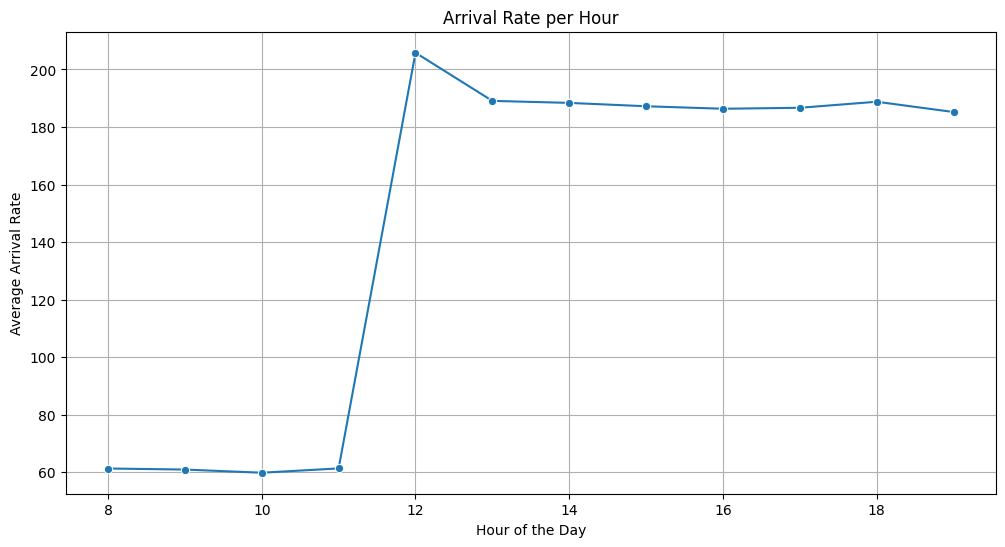

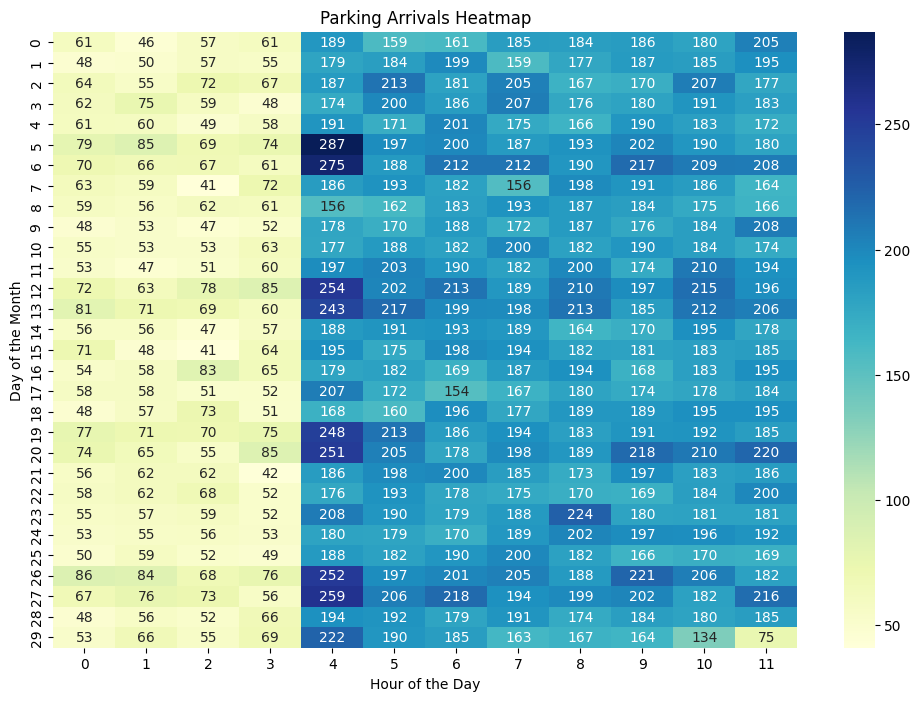

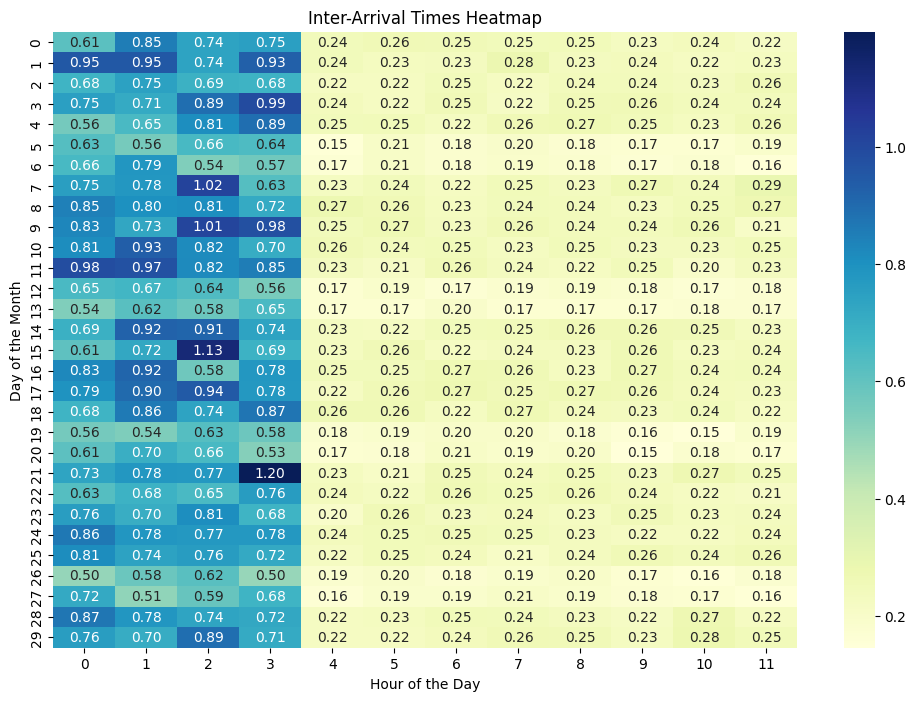

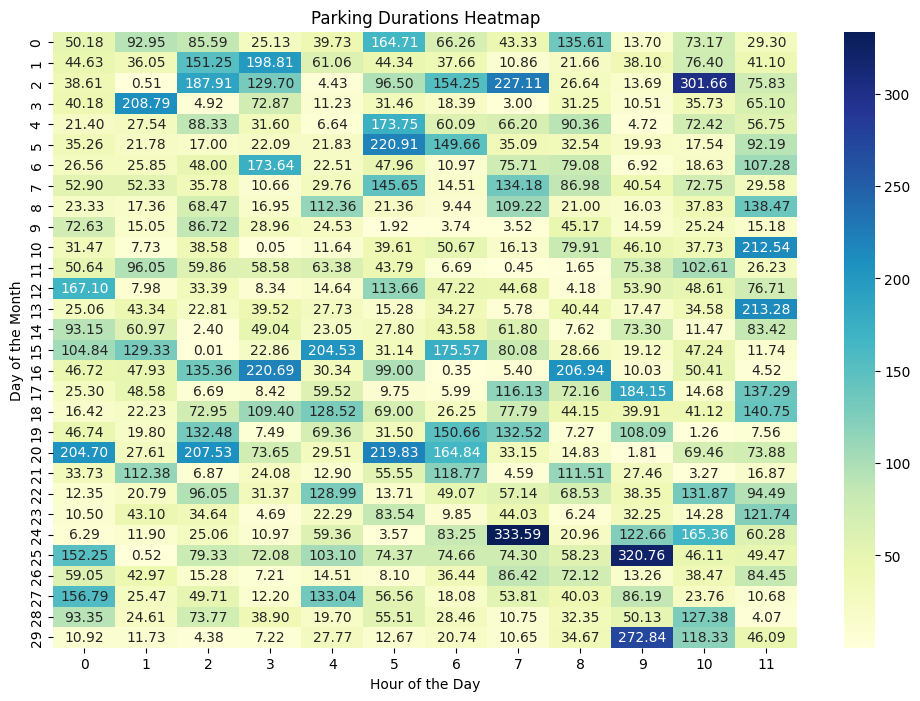


Detailed Results:
arrival_rate_per_hour: [ 61.33333333  60.96666667  59.86666667  61.36666667 205.8
 189.06666667 188.36666667 187.2        186.33333333 186.66666667
 188.76666667 185.2       ]
parking_space_utilization: 13.61111111111111
total_revenue_before_discount: 203397500.0
total_revenue_after_discount: 185625000.0
total_revenue_shopping: 11347945600
lost_customers_due_to_price: 62.243336822610516
lost_customers_due_to_full: 20.613575972300506
lost_customers_due_to_WTV: 17.143087205088978


In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 200
WILLINGNESS_TO_VISIT = 0.80  # 80% willingness to visit (predefined threshold)
SHOPPING_PROBABILITY = 0.60  # 60% chance that a parked vehicle will shop

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Monday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Tuesday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Wednesday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Thursday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Friday': [(8, 12, 100), (12, 17, 350), (17, 20, 400)],
    'Saturday': [(8, 12, 100), (12, 17, 350), (17, 20, 400)]
}

# Initialize data for tracking arrivals, inter-arrival times, parking durations, revenue, and parking space utilization
arrival_pattern = np.zeros((30, 12))  # 30 days, 12 hours per day (8 AM to 8 PM)
inter_arrival_times = [[] for _ in range(30 * 12)]  # List of lists for storing inter-arrival times for each time slot
parking_durations = []  # List to store parking durations
charges_before_discount = []  # List to store parking charges before discount
charges_after_discount = []  # List to store parking charges after discount
total_revenue_parking_before_discount = 0  # Total parking revenue before discount
total_revenue_parking_after_discount = 0  # Total parking revenue after discount
total_revenue_shopping = 0  # Total shopping revenue accumulator
lost_customers_due_to_price = 0  # Lost customers due to dissatisfaction with price
lost_customers_due_to_full = 0  # Lost customers due to parking lot being full
lost_customers_due_to_WTV = 0  # Lost customers due to WTV below threshold
parked_customers = 0  # Parked customers accumulator
spending_data = []  # List to store shopping spending
customer_log = []  # List to store detailed log of each customer
revenue_lost_due_to_WTV = 0  # Revenue lost due to WTV falling below threshold

# WTV formula parameters
x = -1.27056
y = -0.00159

# Spending parameters
mean_spending = 5000  # Mean for the exponential distribution for shopping
lambda_spending = 1 / mean_spending  # Rate parameter for the exponential distribution

def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def calculate_charge(parking_duration, discount=0):
    """Calculate the charge based on parking duration with ceiling logic and apply discount."""
    if parking_duration < 30:
        return 15 - discount
    else:
        hours = np.ceil(parking_duration / 60)  # Round up to the nearest hour
        return 25 * hours - discount  # Charge ₹25 per hour

def calculate_wtv(spending):
    """Calculate the WTV based on the shopping amount and fixed parameters."""
    return x * 25 + y * spending + 115  # WTV formula

def vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time):
    """Simulates vehicle parking behavior, tracks arrivals, inter-arrival times, and calculates revenue."""
    global total_revenue_parking_before_discount, total_revenue_parking_after_discount
    global lost_customers_due_to_price, lost_customers_due_to_full, parked_customers
    global total_revenue_shopping, customer_log, lost_customers_due_to_WTV, revenue_lost_due_to_WTV
    global charges_before_discount, charges_after_discount

    # Check if the vehicle decides to park based on willingness to visit
    if np.random.random() > WILLINGNESS_TO_VISIT:
        lost_customers_due_to_price += 1
        return  # Vehicle leaves without parking
    
    with parking_lot.request() as request:
        yield request | env.timeout(0)  # Attempt to acquire a parking space

        if not request.triggered:  # If the request was not triggered, parking is full
            lost_customers_due_to_full += 1
            return  # Vehicle leaves without parking

        # Successfully parked
        parked_customers += 1

        # Generate parking duration (in minutes)
        parking_duration = np.random.exponential(60)  # Exponential distribution with mean 60 minutes
        parking_durations.append(parking_duration)  # Store parking duration

        # Calculate the parking charge before discount
        charge_before_discount = calculate_charge(parking_duration)
        charges_before_discount.append(charge_before_discount)
        total_revenue_parking_before_discount += charge_before_discount  # Update total parking revenue before discount
        
        # Determine if the customer will shop (60% chance)
        if np.random.random() >= SHOPPING_PROBABILITY:
            # Generate shopping spending based on exponential distribution
            spending = np.random.exponential(scale=mean_spending)
            spending_rounded = round(spending)
            spending_data.append(spending_rounded)
            total_revenue_shopping += spending_rounded

            # Determine discount and final parking charge
            if spending_rounded > 5000:
                if parking_duration < 30:
                    discount = 15
                else:
                    discount = 25
            else:
                discount = 0
            
            charge_after_discount = max(charge_before_discount - discount, 0)  # Ensure charge is not negative
            charges_after_discount.append(charge_after_discount)
            total_revenue_parking_after_discount += charge_after_discount  # Update total parking revenue after discount

            # Calculate WTV of the customer
            wtv_of_arrived_customer = calculate_wtv(spending_rounded)

            # If WTV is less than 50, consider the customer lost due to WTV below threshold
            if wtv_of_arrived_customer < 70:
                lost_customers_due_to_WTV += 1
                revenue_lost_due_to_WTV += charge_after_discount
                return  # Customer leaves, no parking revenue

            # Log customer details
            customer_log.append({
                'Parking Duration (mins)': round(parking_duration, 2),
                'Shopping Amount': spending_rounded,  # Rounded shopping amount
                'Parking Charge Before Discount': charge_before_discount,
                'Discount': discount,
                'Final Parking Charge': charge_after_discount,
                'WTV': round(wtv_of_arrived_customer, 2)
            })
        else:
            # If the customer does not shop, apply no discount
            discount = 0
            charge_after_discount = charge_before_discount
            charges_after_discount.append(charge_after_discount)
            total_revenue_parking_after_discount += charge_after_discount  # Update total parking revenue after discount

            # Log customer details for non-shoppers
            customer_log.append({
                'Parking Duration (mins)': round(parking_duration, 2),
                'Shopping Amount': 0,  # No shopping amount
                'Parking Charge Before Discount': charge_before_discount,
                'Discount': discount,
                'Final Parking Charge': charge_after_discount,
                'WTV': "N/A"  # Non-shoppers do not have WTV calculated
            })

        yield env.timeout(parking_duration)  # Simulate parking duration

        # Track arrivals for the specific day and hour
        arrival_pattern[day_index, hour_index] += 1
        # Store the inter-arrival time
        inter_arrival_times[day_index * 12 + hour_index].append(inter_arrival_time)

def arrival_process(env, parking_lot):
    """Simulates vehicle arrivals throughout the day based on the time slot and day of the week."""
    global parked_customers
    while True:
        current_time = env.now  # Current time in minutes
        current_hour = int(current_time % 720 / 60) + 8  # Convert minutes to hour (8 AM to 8 PM)
        day_index = int(current_time // 720)  # Convert minutes to day index
        hour_index = int((current_time % 720) // 60)  # Convert minutes to hour index within the day
        day_name = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'][day_index % 7]
        
        # Get the arrival rate based on the current day and hour
        rate = get_arrival_rate(day_name, current_hour)
        
        # Generate inter-arrival time based on exponential distribution
        inter_arrival_time = np.random.exponential(scale=60 / rate)  # Adjust rate as per requirements
        
        # Schedule the next vehicle arrival
        yield env.timeout(inter_arrival_time)

        # Create a new vehicle
        env.process(vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time))

def run_simulation():
    """Run the simulation and collect results."""
    global total_revenue_parking_before_discount, total_revenue_parking_after_discount
    global lost_customers_due_to_price, lost_customers_due_to_full, lost_customers_due_to_WTV
    global parked_customers, arrival_pattern, inter_arrival_times, parking_durations
    global charges_before_discount, charges_after_discount, total_revenue_shopping

    # Initialize results
    total_revenue_parking_before_discount = 0
    total_revenue_parking_after_discount = 0
    total_revenue_shopping = 0
    lost_customers_due_to_price = 0
    lost_customers_due_to_full = 0
    lost_customers_due_to_WTV = 0
    parked_customers = 0
    charges_before_discount.clear()
    charges_after_discount.clear()
    inter_arrival_times = [[] for _ in range(30 * 12)]  # Clear previous data
    parking_durations.clear()
    arrival_pattern.fill(0)  # Clear previous data

    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=CAPACITY)

    # Start the arrival process
    env.process(arrival_process(env, parking_lot))

    # Run the simulation
    env.run(until=SIM_DURATION)

    # Convert lists to numpy arrays for analysis
    inter_arrival_times_flat = [item for sublist in inter_arrival_times for item in sublist]
    inter_arrival_times_array = np.array(inter_arrival_times_flat)
    parking_durations_array = np.array(parking_durations)

    # Calculate average arrival rate per hour
    arrival_rate_per_hour = np.sum(arrival_pattern, axis=0) / 30  # Average over 30 days

    # Calculate parking space utilization
    total_time_lot_full = np.sum([np.sum([1 for slot in day if slot > CAPACITY]) for day in arrival_pattern])
    parking_space_utilization = (total_time_lot_full / (30 * 12)) * 100  # Utilization ratio in percentage

    # Convert revenue and customer metrics to percentage
    total_revenue_parking_before_discount = total_revenue_parking_before_discount * 100
    total_revenue_parking_after_discount = total_revenue_parking_after_discount * 100
    total_revenue_shopping = total_revenue_shopping * 100
    lost_customers_due_to_price_percentage = (lost_customers_due_to_price / (lost_customers_due_to_price + lost_customers_due_to_full + lost_customers_due_to_WTV)) * 100
    lost_customers_due_to_full_percentage = (lost_customers_due_to_full / (lost_customers_due_to_price + lost_customers_due_to_full + lost_customers_due_to_WTV)) * 100
    lost_customers_due_to_WTV_percentage = (lost_customers_due_to_WTV / (lost_customers_due_to_price + lost_customers_due_to_full + lost_customers_due_to_WTV)) * 100

    # Display results
    print(f"Total Revenue Before Discount: {total_revenue_parking_before_discount:.2f}%")
    print(f"Total Revenue After Discount: {total_revenue_parking_after_discount:.2f}%")
    print(f"Total Shopping Revenue: {total_revenue_shopping:.2f}%")
    print(f"Total Lost Customers Due to Price Dissatisfaction: {lost_customers_due_to_price_percentage:.2f}%")
    print(f"Total Lost Customers Due to Full Parking: {lost_customers_due_to_full_percentage:.2f}%")
    print(f"Total Lost Customers Due to WTV: {lost_customers_due_to_WTV_percentage:.2f}%")
    print(f"Parking Space Utilization: {parking_space_utilization:.2f}%")

    # Plot arrival rate per hour
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=np.arange(8, 20), y=arrival_rate_per_hour, marker='o')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Arrival Rate')
    plt.title('Arrival Rate per Hour')
    plt.grid(True)
    plt.show()

    # Plot heatmap of parking arrivals
    plt.figure(figsize=(12, 8))
    sns.heatmap(arrival_pattern, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Day of the Month')
    plt.title('Parking Arrivals Heatmap')
    plt.show()

    # Plot heatmap of inter-arrival times
    plt.figure(figsize=(12, 8))
    inter_arrival_heatmap = np.zeros((30, 12))  # Initialize heatmap matrix
    for day in range(30):
        for hour in range(12):
            if inter_arrival_times[day * 12 + hour]:
                inter_arrival_heatmap[day, hour] = np.mean(inter_arrival_times[day * 12 + hour])

    sns.heatmap(inter_arrival_heatmap, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Day of the Month')
    plt.title('Inter-Arrival Times Heatmap')
    plt.show()

    # Plot heatmap of parking durations
    plt.figure(figsize=(12, 8))
    parking_duration_heatmap = np.zeros((30, 12))  # Initialize heatmap matrix
    for day in range(30):
        for hour in range(12):
            if parking_durations_array.size > 0 and (day * 12 + hour) < len(parking_durations_array):
                parking_duration_heatmap[day, hour] = np.mean([duration for i, duration in enumerate(parking_durations) if (i // 12) == day and (i % 12) == hour])

    sns.heatmap(parking_duration_heatmap, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Day of the Month')
    plt.title('Parking Durations Heatmap')
    plt.show()

    return {
        'arrival_rate_per_hour': arrival_rate_per_hour,
        'parking_space_utilization': parking_space_utilization,
        'total_revenue_before_discount': total_revenue_parking_before_discount,
        'total_revenue_after_discount': total_revenue_parking_after_discount,
        'total_revenue_shopping': total_revenue_shopping,
        'lost_customers_due_to_price': lost_customers_due_to_price_percentage,
        'lost_customers_due_to_full': lost_customers_due_to_full_percentage,
        'lost_customers_due_to_WTV': lost_customers_due_to_WTV_percentage
    }

# Run the simulation
results = run_simulation()

# Print detailed results
print("\nDetailed Results:")
for key, value in results.items():
    print(f"{key}: {value}")
